In [314]:
%matplotlib inline

from pymongo import MongoClient
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [315]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return float(us1) / us2

try:
    import config
    print('using local config file')
    mongodb_uri = config.mongodb_uri
except:
    print('using environment variable')
    mongodb_uri = os.getenv('MONGODB_URI')

using local config file


In [316]:
print("Analyzing Data")
success = True

if success:
    try:
        client = MongoClient(mongodb_uri)
        db = client.get_database()
    except Exception as e:
        print('mongo login error ', str(e))
        success = False
if success:
    try:
        dataCursor = db.percentageMove.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        df =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
        increase = df+1
        cumulative = increase.cumprod(axis=0)
        cumulative = cumulative - cumulative.iloc[0]
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False  
        
if success:
    try:
        dataCursor = db.tracking.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        tracking =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False  
        
if success:
    try:
        dataCursor = db.rawPrices.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        raw =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False                


Analyzing Data


/Users/stephan/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


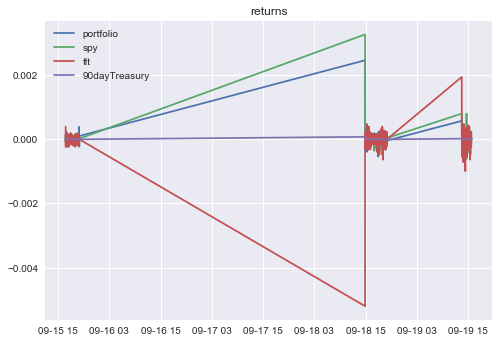

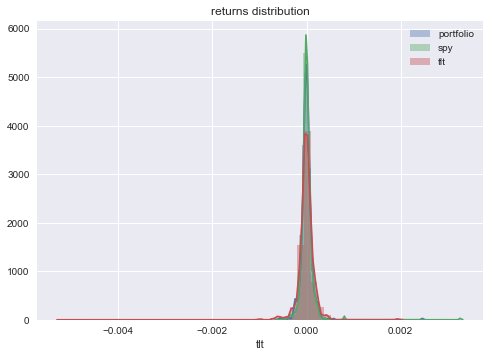

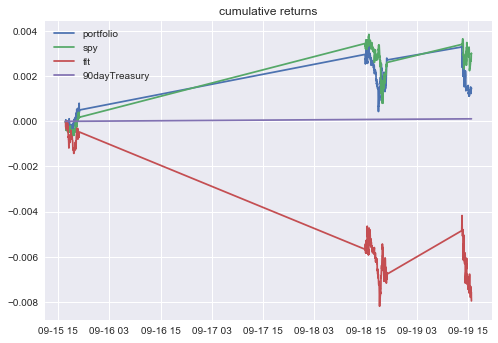

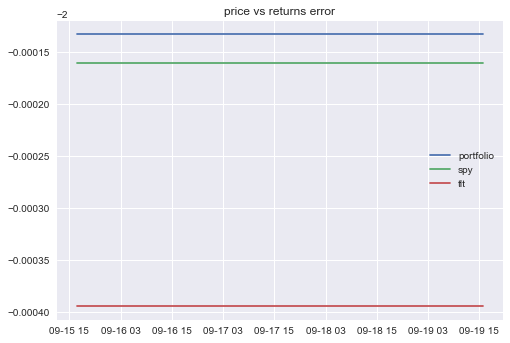

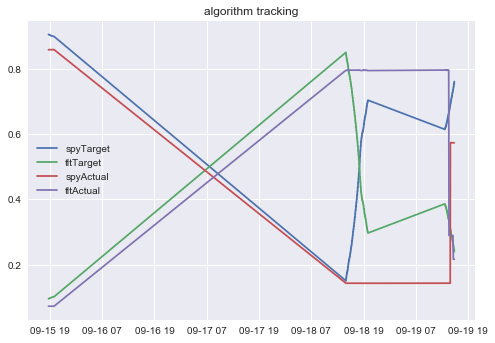

In [317]:
if success:
    plt.figure()
    plt.title('returns')
    plt.plot(df['portfolio'])
    plt.plot(df['spy'])
    plt.plot(df['tlt'])
    plt.plot(df['90dayTreasury'])
    plt.legend()
    
    plt.figure()
    plt.title('returns distribution')
    sns.distplot(df['portfolio'],label="portfolio")
    sns.distplot(df['spy'],label="spy")
    sns.distplot(df['tlt'],label="tlt")
    plt.legend()
    
    plt.figure()
    plt.title('cumulative returns')
    plt.plot(cumulative['portfolio'])
    plt.plot(cumulative['spy'])
    plt.plot(cumulative['tlt'])
    plt.plot(cumulative['90dayTreasury'])
    plt.legend()
    
    plt.figure()
    plt.title('price vs returns error')
    plt.plot(cumulative['portfolio']-(raw['portfolio']/raw['portfolio'].iloc[0])-1)
    plt.plot(cumulative['spy']-(raw['spy']/raw['spy'].iloc[0])-1)
    plt.plot(cumulative['tlt']-(raw['tlt']/raw['tlt'].iloc[0])-1)
    plt.legend()
    
    plt.figure()
    plt.title('algorithm tracking')
    plt.plot(tracking['spyTarget'])
    plt.plot(tracking['tltTarget'])
    plt.plot(tracking['spyActual'])
    plt.plot(tracking['tltActual'])
    plt.legend()

In [318]:
if success:
    df['elapsed'] = df.index-df.index[0]
    year = datetime.timedelta(days=365)
    percentageOfYear = divtd((df['elapsed'])[-1], year)
    
    df['spyExcess'] = df['spy']-df['90dayTreasury']
    df['tltExcess'] = df['tlt']-df['90dayTreasury']
    df['portfolioExcess'] = df['portfolio']-df['90dayTreasury']
    df['spyInfoExcess'] = df['portfolio']-df['spy']
    df['tltInfoExcess'] = df['portfolio']-df['tlt']
    
    
    meanSpyExcess = df['spyExcess'].mean()
    meanTltExcess = df['tltExcess'].mean()
    meanPortfolioExcess = df['portfolioExcess'].mean()
    meanSpyInfoExcess = df['spyInfoExcess'].mean()
    meanTltInfoExcess = df['tltInfoExcess'].mean()
    
    stdSpyExcess = df['spyExcess'].std()
    stdTltExcess = df['tltExcess'].std()
    stdPortfolioExcess = df['portfolioExcess'].std()
    stdSpyInfoExcess = df['spyInfoExcess'].std()
    stdTltInfoExcess = df['tltInfoExcess'].std()
    
    rawSpySharpe = meanSpyExcess/stdSpyExcess
    spySharpe = math.sqrt(len(df.index)/percentageOfYear)*rawSpySharpe
    print('rawSpySharpe = ',rawSpySharpe)
    print('spySharpe = ',spySharpe)
    
    rawTltSharpe = meanTltExcess/stdTltExcess
    tltSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawTltSharpe
    print('\nrawTltSharpe = ',rawTltSharpe)
    print('tltSharpe = ',tltSharpe)
    
    rawPortfolioSharpe = meanPortfolioExcess/stdPortfolioExcess
    portfolioSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawPortfolioSharpe
    print('\nrawPortfolioSharpe = ',rawPortfolioSharpe)
    print('portfolioSharpe = ',portfolioSharpe)
    
    rawSpyInfo = meanSpyInfoExcess/stdSpyInfoExcess
    spyInfo = math.sqrt(len(df.index)/percentageOfYear)*rawSpyInfo
    print('\nrawSpyInfo = ',rawSpyInfo)
    print('spyInfo = ',spyInfo)
    
    rawTltInfo = meanTltInfoExcess/stdTltInfoExcess
    tltInfo = math.sqrt(len(df.index)/percentageOfYear)*rawTltInfo
    print('\nrawTltInfo = ',rawTltInfo)
    print('tltInfo = ',tltInfo)

rawSpySharpe =  0.02920039919610505
spySharpe =  7.04359117008084

rawTltSharpe =  -0.045573259054416865
tltSharpe =  -10.992980024407148

rawPortfolioSharpe =  0.016513185246776103
portfolioSharpe =  3.983237524013571

rawSpyInfo =  -0.01668910092393709
spyInfo =  -4.025671125760193

rawTltInfo =  0.040820268332505905
tltInfo =  9.84648462016645
